In [ ]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords


from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation, TruncatedSVD
import matplotlib.pyplot as plt
import yake
from keybert import KeyBERT

In [18]:
nltk.download('stopwords')
nltk.download('words')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [2]:
# read data
df = pd.read_csv('data-nlp.csv')
df.head()

,Title,Abstract,Keywords
0,Prediction of a natural clay membrane selectiv...,"Heavy metals such as cadmium (Cd), lead (Pb), ...",Ceramic membrane; Clay mineral; Electrochemica...
1,IOT Based Smart Hydroponics System,Currently traditional agriculture soil based m...,Arduino; automated; Hydroponics; Mobileapp; Se...
2,Optimizing photocatalytic dye degradation: A m...,Dye contamination in water sources has severe ...,Bayesian Optimization; HistGradientBoosting (H...
3,Hybrid Intelligent Technique between Supervise...,Water is the secret of life and occupies over ...,Artificial Intelligent; Camel Herd Algorithm; ...
4,Advanced machine vision techniques for groundw...,"This study utilizes three models, namely Weigh...",Comparative Statistical Modeling; Earth observ...


In [3]:
# preprocessing

# case folding
df['Title'] = df['Title'].str.lower()
df['Abstract'] = df['Abstract'].str.lower()
df['Keywords'] = df['Keywords'].str.lower()

# hapus special characters and numbers
def clean_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['Title'] = df['Title'].apply(clean_text)
df['Abstract'] = df['Abstract'].apply(clean_text)
df['Keywords'] = df['Keywords'].apply(clean_text)

# hapus kata-kata non-english
def remove_non_english(text):
    words = nltk.word_tokenize(text)
    english_words = set(nltk.corpus.words.words())
    words = [w for w in words if w.lower() in english_words]
    return ' '.join(words)

df['Title'] = df['Title'].apply(remove_non_english)
df['Abstract'] = df['Abstract'].apply(remove_non_english) 
df['Keywords'] = df['Keywords'].apply(remove_non_english)

# hapus stopwords
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    words = text.split()
    words = [w for w in words if w not in stop_words]
    return ' '.join(words)

df['Title'] = df['Title'].apply(remove_stopwords)
df['Abstract'] = df['Abstract'].apply(remove_stopwords)
df['Keywords'] = df['Keywords'].apply(remove_stopwords)

In [4]:
df.head()

,Title,Abstract,Keywords
0,prediction natural clay membrane selectivity t...,heavy cadmium lead copper among toxic environm...,ceramic membrane clay mineral electrochemical ...
1,based smart hydroponics system,currently traditional agriculture soil based m...,hydroponics sensor web interface
2,photocatalytic dye degradation machine learnin...,dye contamination water severe environmental p...,optimization model machine learning methylene ...
3,hybrid intelligent technique unsupervised mach...,water secret life surface become necessary pro...,artificial intelligent camel herd algorithm ma...
4,advanced machine vision level prediction model...,study three namely weight evidence woe frequen...,comparative statistical modeling earth observa...


In [5]:
# feature extraction
text_data = df['Title'] + ' ' + df['Abstract'] + ' ' + df['Keywords']

# TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
tfidf_matrix = tfidf_vectorizer.fit_transform(text_data)


## 1. Perbandingan dengan Groundtruth UTS

In [6]:
groundtruth_df = pd.read_csv("Excel_Groundtruth_F_Final_Kelompok F.csv")

# ekstrak kata kunci/frasa unik dari groundtruth
unique_keywords = groundtruth_df['Keyword / Phrase'].unique()
print(unique_keywords[:10])


['riparian zone restoration' 'lakes' 'lake' 'ecosystem rehabilitation'
 'rehabilitation of water ecosystem' 'rehabilitation of water ecosystems'
 'rehabilitation of the water ecosystem'
 'rehabilitation of the water ecosystems' 'rehabilitate water ecosystem'
 'rehabilitate water ecosystems']


In [7]:
for idx, row in enumerate(text_data):
    matching_keywords = []
    text = row.lower()
    
    for keyword in unique_keywords:
        if str(keyword).lower() in text:
            matching_keywords.append(keyword)
            
    print(f"Jurnal {idx + 1}: {len(matching_keywords)} keyword groundtruth ditemukan")
    if matching_keywords:
        print(f"Keywords: {', '.join(matching_keywords)}")
    print()


Jurnal 1: 7 keyword groundtruth ditemukan
Keywords: water, rat, ceramic, filtration, removal, membrane, city

Jurnal 2: 10 keyword groundtruth ditemukan
Keywords: water, agriculture, water scarcity, management, scarcity, rat, well water, urban, city, soil

Jurnal 3: 9 keyword groundtruth ditemukan
Keywords: water, contamination, rat, water treatment, treatment, Water treatment, dye, city, remediation

Jurnal 4: 12 keyword groundtruth ditemukan
Keywords: protect, water, water resource management, water resource, sustainable, management, water Resource, water quality, pollution, improve water quality, Water quality, THM

Jurnal 5: 5 keyword groundtruth ditemukan
Keywords: sustainable, management, sustainable management, rat, soil

Jurnal 6: 11 keyword groundtruth ditemukan
Keywords: protect, water, water resource management, water resource, management, agricultural, industrial, water Resource, rat, water quality, Water quality

Jurnal 7: 15 keyword groundtruth ditemukan
Keywords: river, 

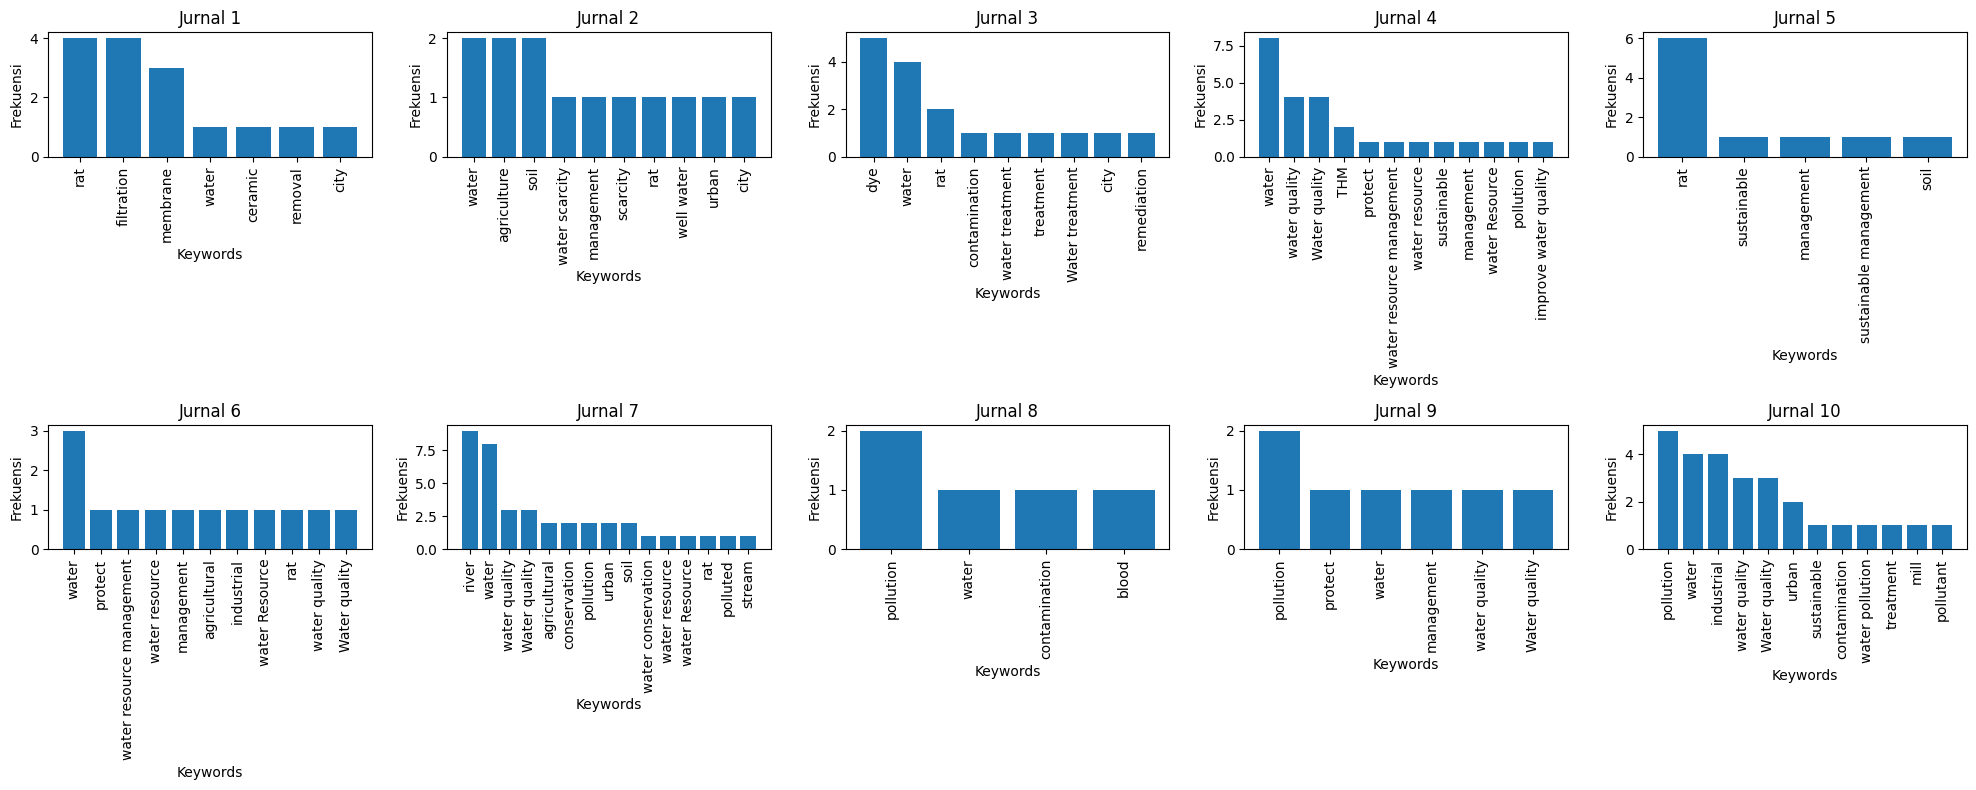

In [8]:
journal_keyword_counts = {}

# hitung frekuensi keyword untuk setiap jurnal
for idx, row in df.iterrows():
    combined_text = f"{row['Title']} {row['Abstract']} {row['Keywords']}".lower()
    keyword_counts = {}
    
    for keyword in unique_keywords:
        keyword_lower = str(keyword).lower()
        if keyword_lower in combined_text:
            keyword_counts[keyword] = combined_text.count(keyword_lower)
            
    journal_keyword_counts[idx] = dict(sorted(keyword_counts.items(), key=lambda x: x[1], reverse=True))

plt.figure(figsize=(20, 8))
for idx in range(len(df)):
    plt.subplot(2, 5, idx+1)
    
    if len(journal_keyword_counts[idx]) > 0:
        plt.bar(range(len(journal_keyword_counts[idx])), 
                list(journal_keyword_counts[idx].values()))
        plt.xticks(range(len(journal_keyword_counts[idx])), 
                   list(journal_keyword_counts[idx].keys()), 
                   rotation=90)
    
    plt.title(f'Jurnal {idx+1}')
    plt.xlabel('Keywords')
    plt.ylabel('Frekuensi')

plt.tight_layout()
plt.show()


## 2. Topic Modelling

#### 2.1 Non-negative Matrix Factorization (NMF)

In [ ]:
# membuat fungsi untuk menghitung coherence score
import numpy as np
from gensim.models.coherencemodel import CoherenceModel

tokens_list = [text.split() for text in text_data]


def get_topics_words_from_components(components_matrix, feature_names, topn=10):
    topics = []
    for topic_vec in components_matrix:
        top_indices = topic_vec.argsort()[-topn:][::-1]
        topics.append([feature_names[i] for i in top_indices])
    return topics


def compute_coherence_over_k(method, k_values, vector_matrix, feature_names, topn=10, random_state=42):
    scores = []
    topics_per_k = {}
    for k in k_values:
        if method == 'nmf':
            model = NMF(n_components=k, random_state=random_state)
            model.fit(vector_matrix)
            components = model.components_
        elif method == 'lda':
            model = LatentDirichletAllocation(n_components=k, random_state=random_state)
            model.fit(vector_matrix)
            components = model.components_
        elif method == 'lsa':
            model = TruncatedSVD(n_components=k, random_state=random_state)
            model.fit(vector_matrix)
            components = model.components_
        else:
            raise ValueError('Unknown method')
        topics = get_topics_words_from_components(components, feature_names, topn=topn)
        topics_per_k[k] = topics
        cm = CoherenceModel(topics=topics, texts=tokens_list, coherence='c_v')
        scores.append(cm.get_coherence())
    return np.array(k_values), np.array(scores), topics_per_k


# coherence score untuk NMF
k_values = list(range(2, 11))
feature_names = tfidf_vectorizer.get_feature_names_out()

k_arr, coh_scores, nmf_topics_dict = compute_coherence_over_k(
    method='nmf',
    k_values=k_values,
    vector_matrix=tfidf_matrix,
    feature_names=feature_names,
    topn=10,
    random_state=42,
)

best_k_nmf = int(k_arr[np.argmax(coh_scores)])
print(f'n_topics: {best_k_nmf}')

plt.figure(figsize=(6,4))
plt.plot(k_arr, coh_scores, marker='o')
plt.title('Coherence Score vs n_topics (NMF)')
plt.xlabel('n_topics')
plt.ylabel('Coherence (c_v)')
plt.grid(True)
plt.show()


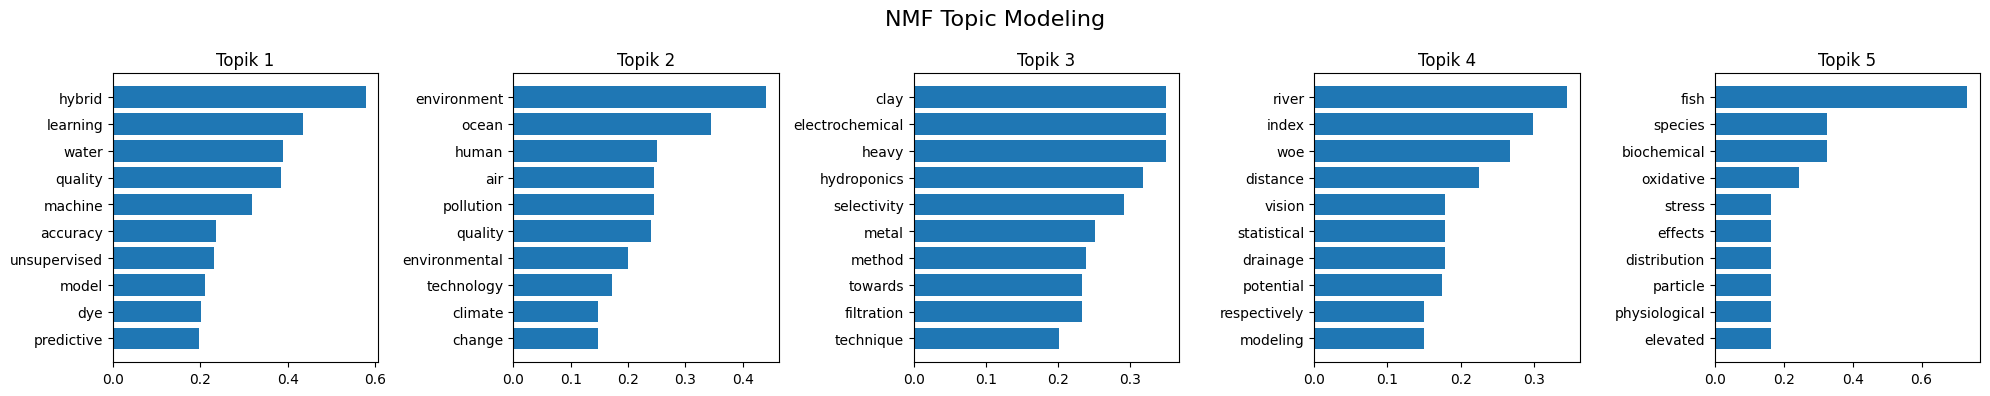

In [ ]:
n_topics = best_k_nmf
nmf_model = NMF(n_components=n_topics, random_state=42)
doc_topics = nmf_model.fit_transform(tfidf_matrix)

# ambil feature names dan kata teratas untuk tiap topik
feature_names = tfidf_vectorizer.get_feature_names_out()
n_top_words = 10

fig, axes = plt.subplots(1, n_topics, figsize=(4*n_topics, 4))
fig.suptitle('NMF Topic Modeling', fontsize=16)

for topic_idx, topic in enumerate(nmf_model.components_):
    top_words_idx = topic.argsort()[:-n_top_words-1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    top_scores = [topic[i] for i in top_words_idx]
    
    axes[topic_idx].barh(range(len(top_words)), top_scores)
    axes[topic_idx].set_yticks(range(len(top_words)))
    axes[topic_idx].set_yticklabels(top_words)
    axes[topic_idx].set_title(f'Topik {topic_idx + 1}')
    axes[topic_idx].invert_yaxis()

plt.tight_layout()
plt.show()


In [10]:
for idx, doc_topics in enumerate(doc_topics):
    dominant_topic = doc_topics.argmax() + 1
    print(f"Jurnal {idx + 1}: Topik {dominant_topic}")

Jurnal 1: Topik 3
Jurnal 2: Topik 3
Jurnal 3: Topik 1
Jurnal 4: Topik 1
Jurnal 5: Topik 4
Jurnal 6: Topik 1
Jurnal 7: Topik 4
Jurnal 8: Topik 5
Jurnal 9: Topik 2
Jurnal 10: Topik 2


#### 2.2 Latent Dirichlet Allocation (LDA)

In [ ]:
# coherence untuk LDA
k_values = list(range(2, 11))
feature_names = tfidf_vectorizer.get_feature_names_out()

k_arr_lda, coh_scores_lda, lda_topics_dict = compute_coherence_over_k(
    method='lda',
    k_values=k_values,
    vector_matrix=tfidf_matrix,
    feature_names=feature_names,
    topn=10,
    random_state=42,
)

best_k_lda = int(k_arr_lda[np.argmax(coh_scores_lda)])
print(f'Best n_topics for LDA by coherence: {best_k_lda}')

plt.figure(figsize=(6,4))
plt.plot(k_arr_lda, coh_scores_lda, marker='o', color='orange')
plt.title('Coherence Score vs n_topics (LDA)')
plt.xlabel('n_topics')
plt.ylabel('Coherence (c_v)')
plt.grid(True)
plt.show()


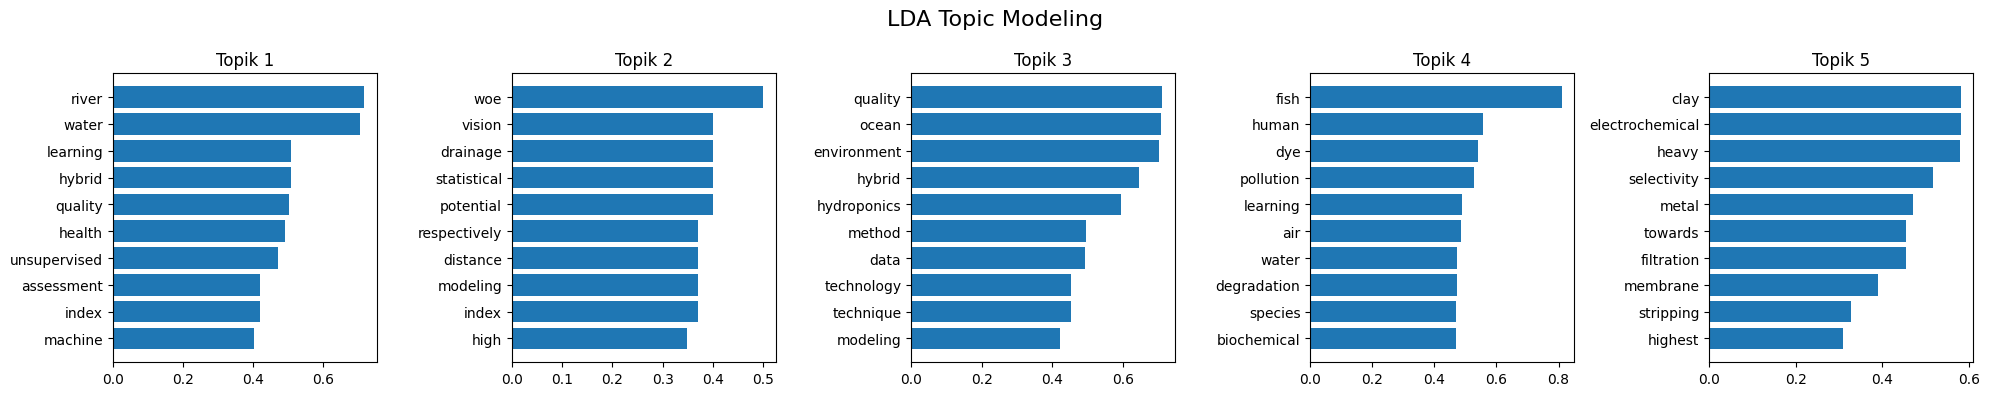

In [ ]:
n_topics = best_k_lda
lda_model = LatentDirichletAllocation(n_components=n_topics, random_state=42)
lda_output = lda_model.fit_transform(tfidf_matrix)

fig, axes = plt.subplots(1, n_topics, figsize=(4*n_topics, 4))
fig.suptitle('LDA Topic Modeling', fontsize=16)

for topic_idx, topic in enumerate(lda_model.components_):
    top_words_idx = topic.argsort()[:-n_top_words-1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    top_scores = [topic[i] for i in top_words_idx]
    
    axes[topic_idx].barh(range(len(top_words)), top_scores)
    axes[topic_idx].set_yticks(range(len(top_words)))
    axes[topic_idx].set_yticklabels(top_words)
    axes[topic_idx].set_title(f'Topik {topic_idx + 1}')
    axes[topic_idx].invert_yaxis()

plt.tight_layout()
plt.show()

In [12]:
for idx, doc_topics in enumerate(lda_output):
    dominant_topic = doc_topics.argmax() + 1
    print(f"Jurnal {idx + 1}: Topik {dominant_topic}")

Jurnal 1: Topik 5
Jurnal 2: Topik 3
Jurnal 3: Topik 4
Jurnal 4: Topik 1
Jurnal 5: Topik 2
Jurnal 6: Topik 3
Jurnal 7: Topik 1
Jurnal 8: Topik 4
Jurnal 9: Topik 3
Jurnal 10: Topik 4


#### 2.3 Latent Semantic Analysis (LSA)


In [ ]:
# coherence untuk LSA
k_values = list(range(2, 11))
feature_names = tfidf_vectorizer.get_feature_names_out()

k_arr_lsa, coh_scores_lsa, lsa_topics_dict = compute_coherence_over_k(
    method='lsa',
    k_values=k_values,
    vector_matrix=tfidf_matrix,
    feature_names=feature_names,
    topn=10,
    random_state=42,
)

best_k_lsa = int(k_arr_lsa[np.argmax(coh_scores_lsa)])
print(f'Best n_topics for LSA by coherence: {best_k_lsa}')

plt.figure(figsize=(6,4))
plt.plot(k_arr_lsa, coh_scores_lsa, marker='o', color='green')
plt.title('Coherence Score vs n_topics (LSA)')
plt.xlabel('n_topics')
plt.ylabel('Coherence (c_v)')
plt.grid(True)
plt.show()


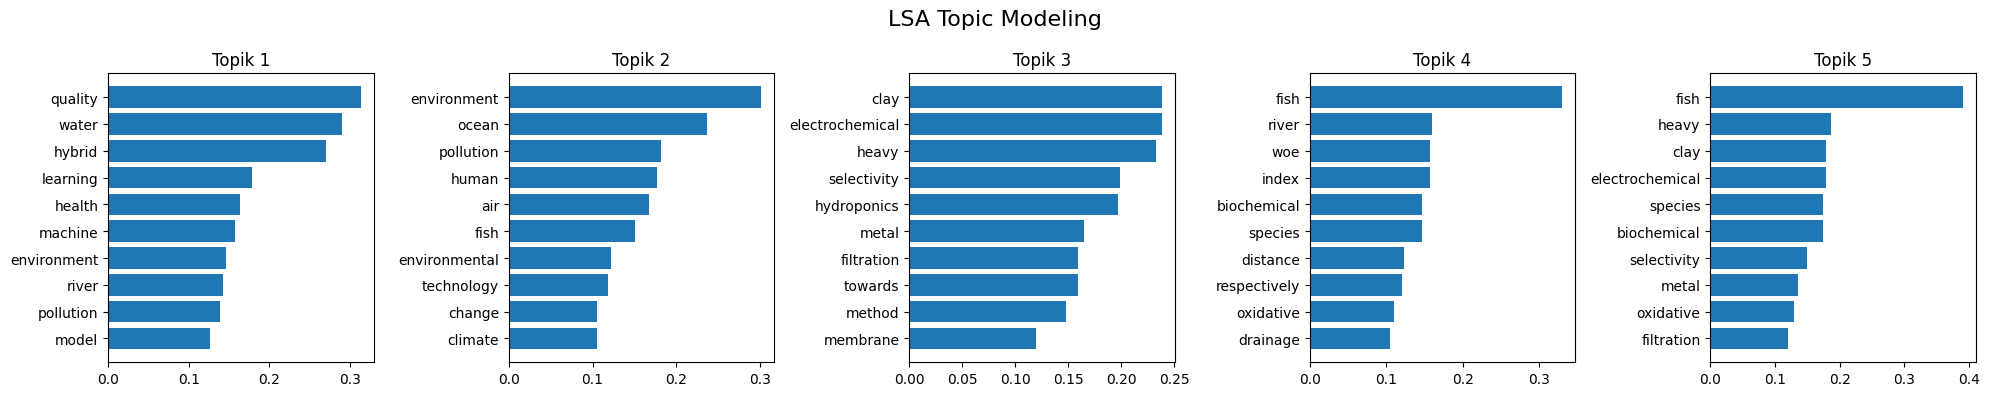

In [ ]:
n_topics = best_k_lsa
lsa_model = TruncatedSVD(n_components=n_topics, random_state=42)
lsa_output = lsa_model.fit_transform(tfidf_matrix)

fig, axes = plt.subplots(1, n_topics, figsize=(4*n_topics, 4))
fig.suptitle('LSA Topic Modeling', fontsize=16)

for topic_idx, topic in enumerate(lsa_model.components_):
    top_words_idx = topic.argsort()[:-n_top_words-1:-1]
    top_words = [feature_names[i] for i in top_words_idx]
    top_scores = [topic[i] for i in top_words_idx]
    
    axes[topic_idx].barh(range(len(top_words)), top_scores)
    axes[topic_idx].set_yticks(range(len(top_words)))
    axes[topic_idx].set_yticklabels(top_words)
    axes[topic_idx].set_title(f'Topik {topic_idx + 1}')
    axes[topic_idx].invert_yaxis()

plt.tight_layout()
plt.show()


In [14]:
for idx, doc_topics in enumerate(lsa_output):
    dominant_topic = doc_topics.argmax() + 1
    print(f"Jurnal {idx + 1}: Topik {dominant_topic}")

Jurnal 1: Topik 3
Jurnal 2: Topik 3
Jurnal 3: Topik 1
Jurnal 4: Topik 1
Jurnal 5: Topik 4
Jurnal 6: Topik 1
Jurnal 7: Topik 1
Jurnal 8: Topik 5
Jurnal 9: Topik 2
Jurnal 10: Topik 2


## 3. Keywords Extraction

#### 3.1 TF-IDF

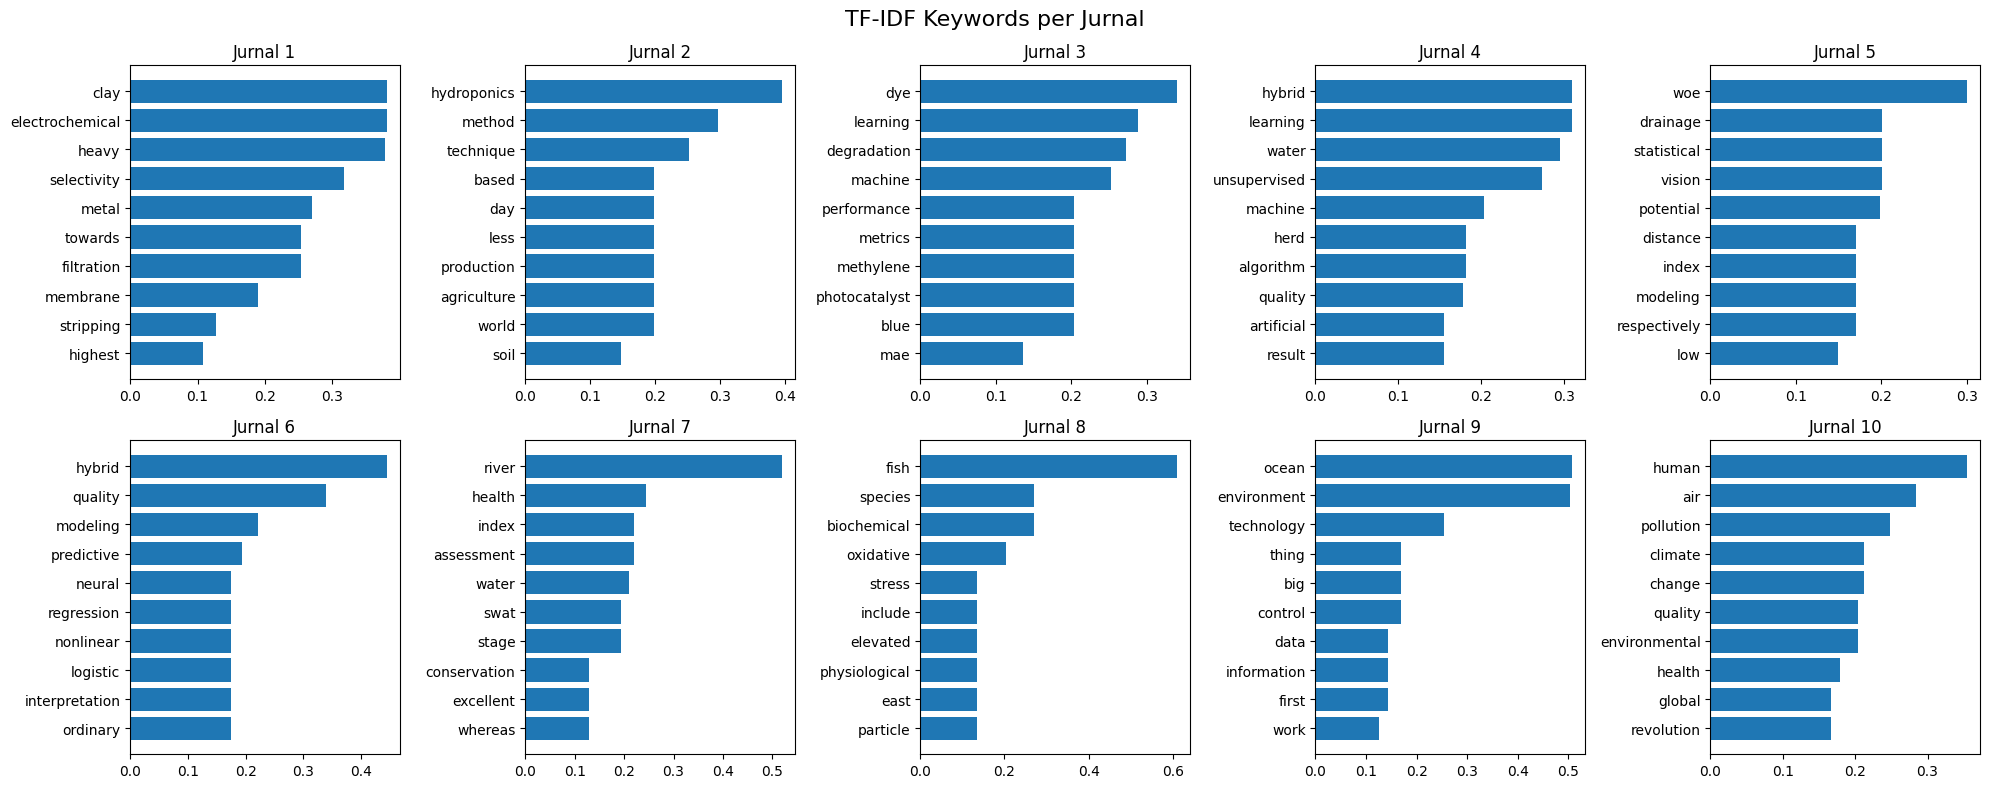

In [15]:
n_keywords = 10

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('TF-IDF Keywords per Jurnal', fontsize=16)

for i in range(10):
    doc_tfidf = tfidf_matrix[i].toarray()[0]
    top_indices = doc_tfidf.argsort()[-n_keywords:][::-1]
    
    top_words = [feature_names[idx] for idx in top_indices]
    top_scores = [doc_tfidf[idx] for idx in top_indices]
    
    row = i // 5
    col = i % 5
    
    axes[row, col].barh(range(len(top_words)), top_scores)
    axes[row, col].set_yticks(range(len(top_words)))
    axes[row, col].set_yticklabels(top_words)
    axes[row, col].set_title(f'Jurnal {i+1}')
    axes[row, col].invert_yaxis()

plt.tight_layout()
plt.show()


#### 3.2 Yake

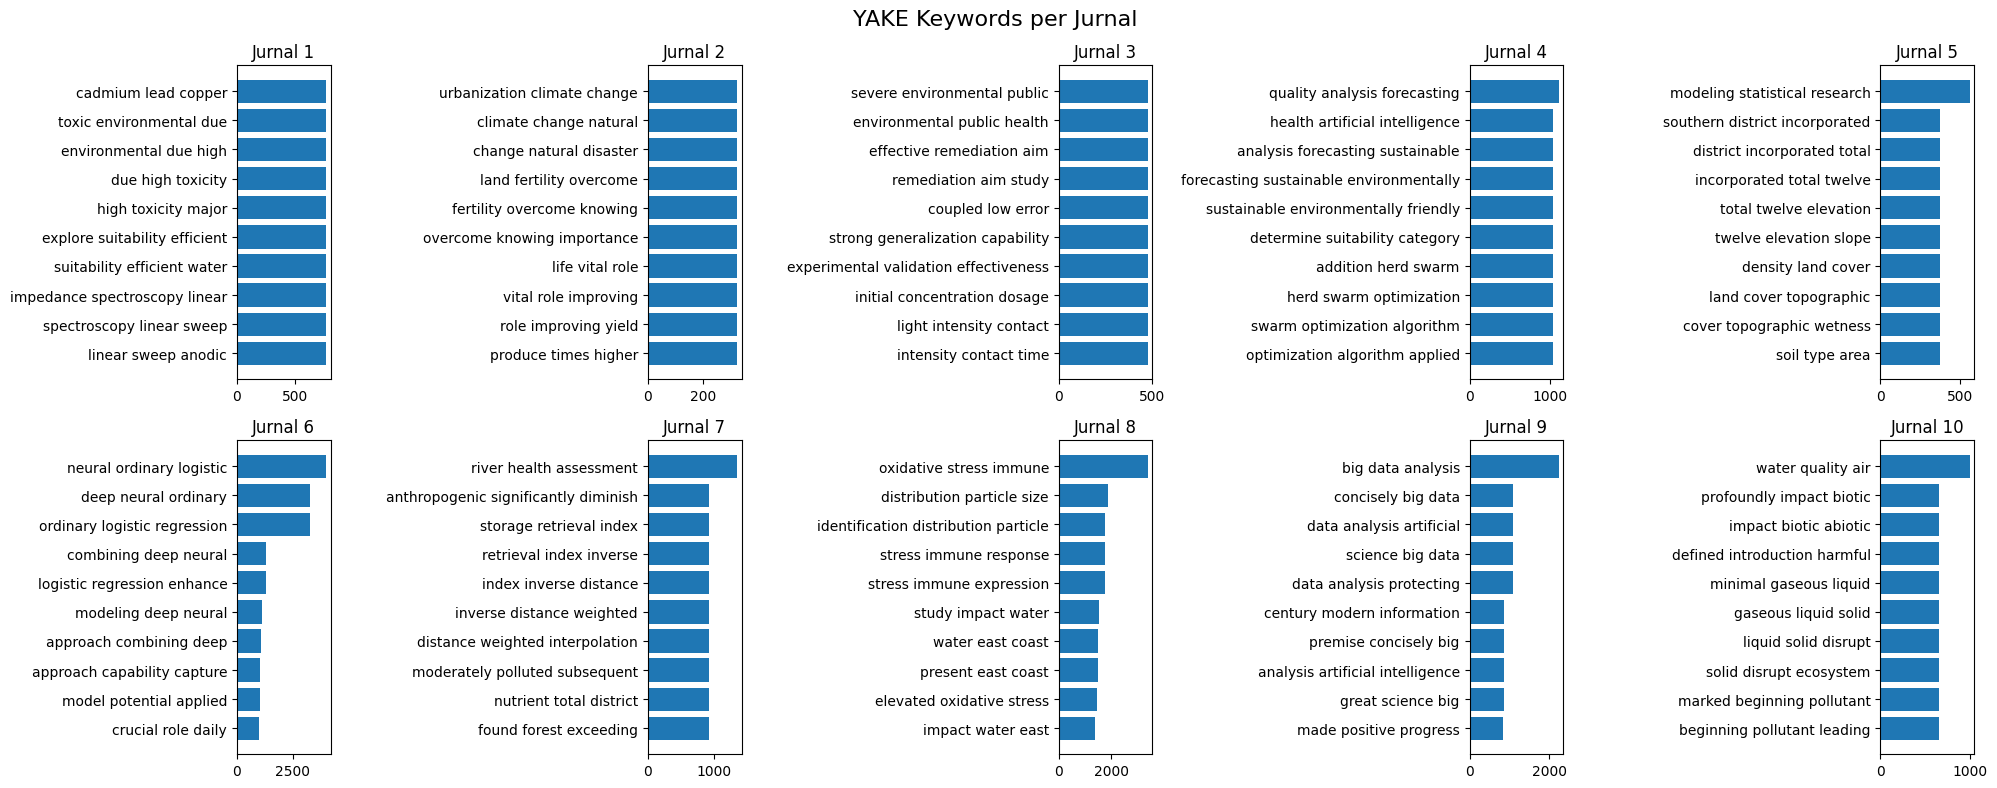

In [16]:
# inisialisasi yake keyword extractor
kw_extractor = yake.KeywordExtractor(
    lan="en", 
    n=3, 
    dedupLim=0.9,
    dedupFunc='seqm',
    windowsSize=1,
    top=10,
    features=None
)

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('YAKE Keywords per Jurnal', fontsize=16)

# ekstraksi keyword untuk setiap dokumen
for i in range(10):
    # mendapatkan keyword menggunakan yake
    text = df['Abstract'].iloc[i] + " " + df['Title'].iloc[i]
    keywords = kw_extractor.extract_keywords(text)
    
    keywords.sort(key=lambda x: x[1])
    
    top_words = [kw[0] for kw in keywords[:n_keywords]]
    top_scores = [1/kw[1] for kw in keywords[:n_keywords]]  
    
    row = i // 5
    col = i % 5
    
    axes[row, col].barh(range(len(top_words)), top_scores)
    axes[row, col].set_yticks(range(len(top_words)))
    axes[row, col].set_yticklabels(top_words)
    axes[row, col].set_title(f'Jurnal {i+1}')
    axes[row, col].invert_yaxis()

plt.tight_layout()
plt.show()


#### 3.3 KeyBERT

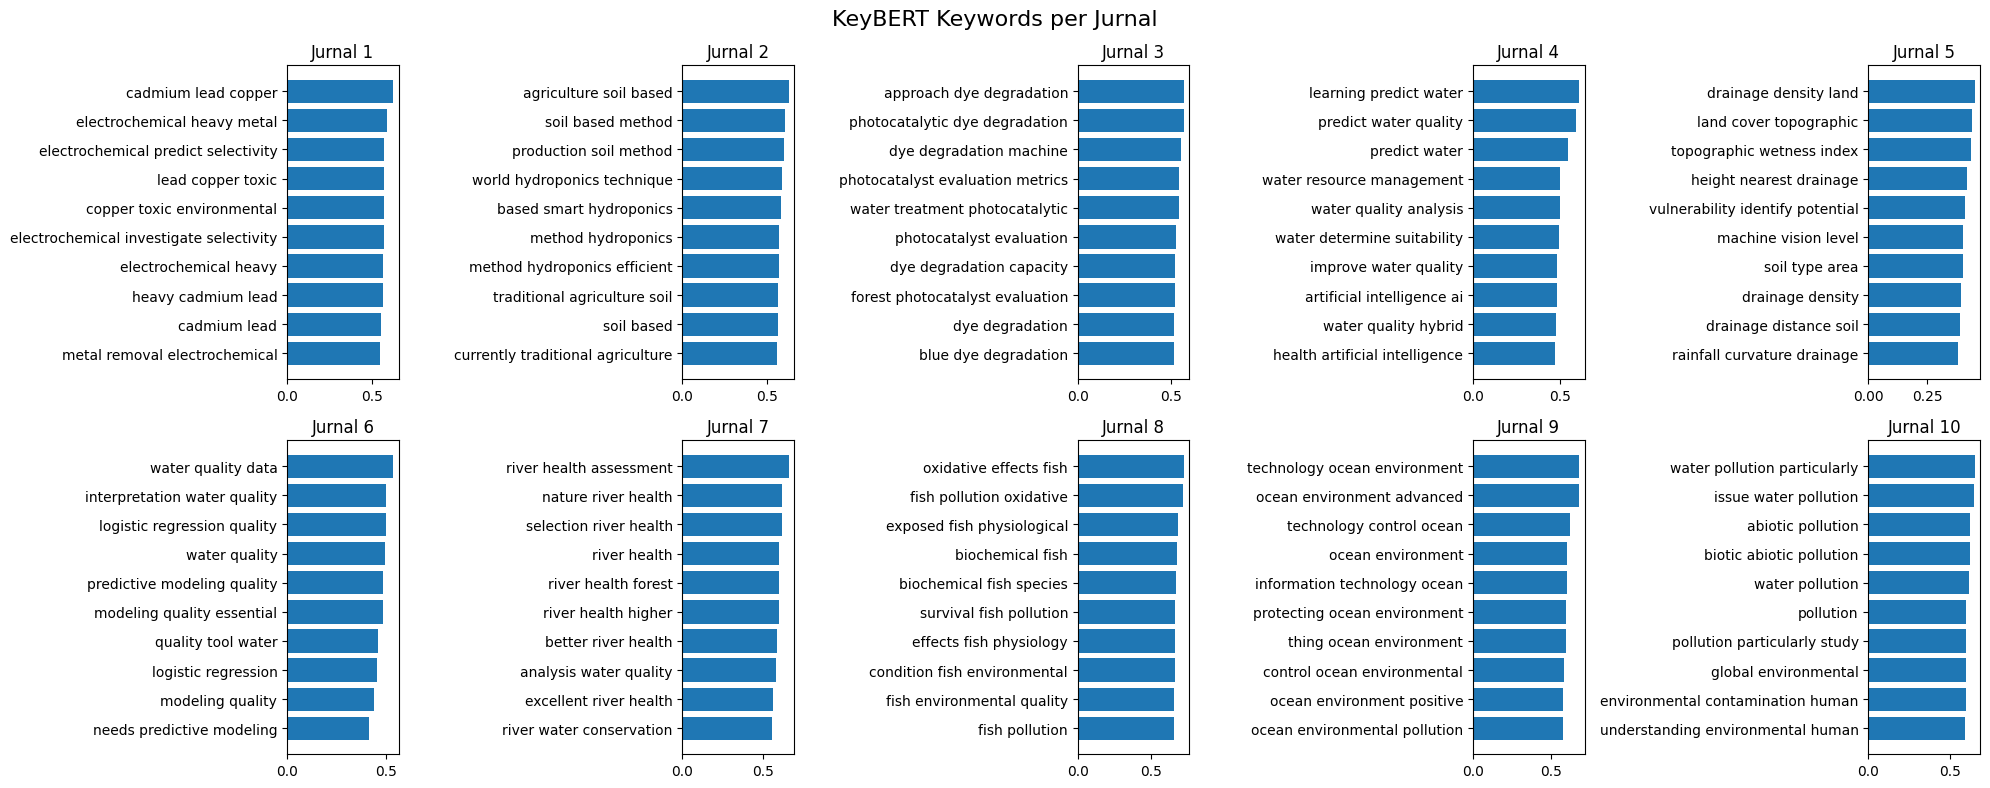

In [17]:
# inisialisasi keybert keyword extractor
kw_extractor = KeyBERT()

fig, axes = plt.subplots(2, 5, figsize=(20, 8))
fig.suptitle('KeyBERT Keywords per Jurnal', fontsize=16)

# ekstraksi keyword untuk setiap dokumen
for i in range(10):
    # mendapatkan keyword menggunakan keybert
    text = df['Abstract'].iloc[i] + " " + df['Title'].iloc[i]
    keywords = kw_extractor.extract_keywords(text, 
                                           keyphrase_ngram_range=(1, 3),
                                           stop_words='english',
                                           top_n=n_keywords)
    
    top_words = [kw[0] for kw in keywords]
    top_scores = [kw[1] for kw in keywords]
    
    row = i // 5
    col = i % 5
    
    axes[row, col].barh(range(len(top_words)), top_scores)
    axes[row, col].set_yticks(range(len(top_words)))
    axes[row, col].set_yticklabels(top_words)
    axes[row, col].set_title(f'Jurnal {i+1}')
    axes[row, col].invert_yaxis()

plt.tight_layout()
plt.show()
